#  Person Vehicle Bike Detection 

# 1.Imports

In [1]:
# Importing basic packages required
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core
%matplotlib inline

# 2.Download Models

We need to download pretrained models to continue our progress.We use omz_downloader, a command-line tool installed by openvino-dev package.

Note: If you want to change the model,you need to modify the model name,such as "person-vehicle-bike-detection-2003","vehicle-detection-0202" .They support different image input sizes in detections.If you want to change the precision,you need to modify the precision value in "FP32", "FP16", "FP16-INT8",different type has different model size and precision value.

In [2]:
model_name = "person-vehicle-bike-detection-2003"

In [3]:
# Directory where model will be downloaded
base_model_dir = "model"
# Model name as named in Open Model Zoo
detection_model_name = "person-vehicle-bike-detection-2003"
# Selected precision (FP32, FP16, FP16-INT8)
precision = "FP32"
# Check the model exists 
detection_model_path = (f"model/intel/{detection_model_name}/{precision}/{detection_model_name}.xml")
p=Path(detection_model_path)
# Download detection model
if not p.exists():
    download_command = f"omz_downloader " \
                       f"--name {detection_model_name} " \
                       f"--precision {precision} " \
                       f"--output_dir {base_model_dir}"
    ! $download_command

# 3.Load Models
In this notebook,we will need detection model and recognition model.When we download models,we need to initialize inference engine(IECore),and use read_network to read network architecture and weights from .xml and .bin files.Then,we load the network on the "CPU" using load_network.

In [4]:
# Initialize inference engine
ie_core = Core()
def model_init(model_path: str):
    """
    Read the network and weights from file, load the
    model on the CPU and get input and output names of nodes

    :param: model: model architecture path *.xml
    :retuns:
            input_key: Input node network
            output_key: Output node network
            exec_net: Encoder model network
            net: Model network
    """
    # Read the network and corresponding weights from file
    model = ie_core.read_model(model=model_path)
    # compile the model for the CPU (you can use GPU or MYRIAD as well)
    compiled_model = ie_core.compile_model(model=model, device_name="CPU")
    # Get input and output names of nodes
    input_keys = compiled_model.inputs[0]
    output_keys = compiled_model.outputs[0]
    return input_keys, output_keys, compiled_model

### 3.1 Get attributes from model


In [5]:
# Detection model initialization
input_key_de, output_keys_de, compiled_model_de = model_init(detection_model_path)
# Get input size - Detection
height_de, width_de = list(input_key_de.shape)[2:]

In [6]:
#Function for showing Raw Image
def plt_img(raw_image):
    """
    Use matplot to show image inline
    raw_image: input image

    :param: raw_image:image array
    """
    plt.figure(figsize=(10, 6))
    plt.axis("off")
    plt.imshow(raw_image)

####  3.2.Read and show a test image
From detection model input shape [1, 3, 480, 864],we need to resize the image size to 864x480 resolution.,and expand batch channel with expand_dims function.

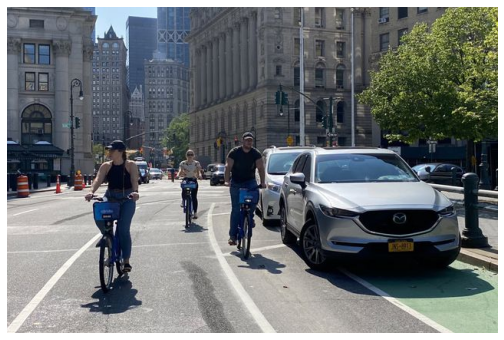

In [7]:
# Read a image
#image_de = cv2.imread("./data/person-vehicle-bike-detection-2003.png")
#image_de = cv2.imread("./data/park.jpg")
image_de = cv2.imread("./data/nyu.jpg")
# Resize to [3, 256, 256]
resized_image_de = cv2.resize(image_de, (width_de, height_de))
# Expand to [1, 3, 256, 256]
input_image_de = np.expand_dims(resized_image_de.transpose(2, 0, 1), 0)
# Show image
plt_img(raw_image=cv2.cvtColor(image_de, cv2.COLOR_BGR2RGB))

In [8]:
# Create inference request
request = compiled_model_de.create_infer_request()
request.infer({input_key_de.any_name: input_image_de})
boxes = request.get_tensor("boxes").data
# Remove zero only boxes
boxes = boxes[~np.all(boxes == 0, axis=1)]

In [9]:
# For each detection, the description has the format: [x_min, y_min, x_max, y_max, conf]
# Image passed here is in BGR format with changed width and height. 
#To display it in colors expected by matplotlib we use cvtColor function
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # Define colors for boxes and descriptions
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}
    # Fetch image shapes to calculate ratio
    (real_y, real_x), (resized_y, resized_x) = bgr_image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y
    # Convert base image from bgr to rgb format
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    # Iterate through non-zero boxes
    for box in boxes:
        # Pick confidence factor from last place in array
        conf = box[-1]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio
            # In case that bounding box is found at the top of the image, 
            # we position upper box bar little lower to make it visible on image 
            (x_min, y_min, x_max, y_max) = [int(max(corner_position * ratio_y, 10)) if idx % 2 
                else int(corner_position * ratio_x)
                for idx, corner_position in enumerate(box[:-1])]
            # Draw box based on position, 
            #parameters in rectangle function are: image, start_point, end_point, color, thickness
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)
            # Add text to image based on position and confidence
            # Parameters in text function are: image, text, bottom-left_corner_textfield, font, font_scale, color, thickness, line_type
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )
    return rgb_image

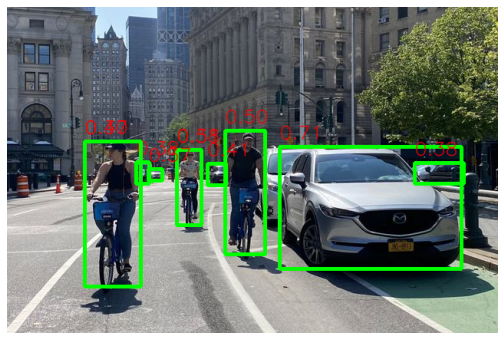

In [10]:
# Detected Image
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(convert_result_to_image(image_de, resized_image_de, boxes, conf_labels=True));